# 神经网络

## 1 数据准备

In [1]:
import struct
import gzip
import os
import numpy as np
import tensorflow as tf
from six.moves.urllib.request import urlretrieve

def maybe_download(url, filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        # 将远程数据下载到本地
        filename, _ = urlretrieve(url + filename, filename)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

def read_mnist(fname_img, fname_lbl):
    print('\nReading files %s and %s'%(fname_img, fname_lbl))
    
    with gzip.open(fname_img) as fimg:        
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        print(num,rows,cols)
        img = (np.frombuffer(fimg.read(num*rows*cols), dtype=np.uint8).reshape(num, rows * cols)).astype(np.float32)
        print('(Images) Returned a tensor of shape ',img.shape)
        
        img = (img - np.mean(img))/np.std(img)
        
    with gzip.open(fname_lbl) as flbl:
        # flbl.read(8) reads upto 8 bytes
        magic, num = struct.unpack(">II", flbl.read(8))   
        # 将data以流的形式读取，实现动态数组
        lbl = np.frombuffer(flbl.read(num), dtype=np.int8)  
        print('(Labels) Returned a tensor of shape: %s'%lbl.shape)
        print('Sample labels: ',lbl[:10])
        
    return img, lbl
    
    
# Download data if needed
url = 'http://yann.lecun.com/exdb/mnist/'
# training data
maybe_download(url,'train-images-idx3-ubyte.gz',9912422)  # 训练图片
maybe_download(url,'train-labels-idx1-ubyte.gz',28881)  # 训练标签
# testing data
maybe_download(url,'t10k-images-idx3-ubyte.gz',1648877)  # 预测图片
maybe_download(url,'t10k-labels-idx1-ubyte.gz',4542)  # 预测标签

# Read the training and testing data 
train_inputs, train_labels = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test_inputs, test_labels = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\framework\dtypes.py:5

Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz

Reading files train-images-idx3-ubyte.gz and train-labels-idx1-ubyte.gz
60000 28 28
(Images) Returned a tensor of shape  (60000, 784)
(Labels) Returned a tensor of shape: 60000
Sample labels:  [5 0 4 1 9 2 1 3 1 4]

Reading files t10k-images-idx3-ubyte.gz and t10k-labels-idx1-ubyte.gz
10000 28 28
(Images) Returned a tensor of shape  (10000, 784)
(Labels) Returned a tensor of shape: 10000
Sample labels:  [7 2 1 0 4 1 4 9 5 9]


## 2 定义超参数与常量

In [2]:
WEIGHTS_STRING = 'weights'
BIAS_STRING = 'bias'

batch_size = 100  # 一次训练100个样本

img_width, img_height = 28,28
input_size = img_height * img_width
num_labels = 10

# resets the default graph Otherwise raises an error about already initialized variables
tf.reset_default_graph()

## 3 定义TensorFlow图

In [3]:
tf_inputs = tf.placeholder(shape=[batch_size, input_size], dtype=tf.float32,
                           name='inputs')
tf_labels = tf.placeholder(shape=[batch_size, num_labels], dtype=tf.float32,
                           name='labels')

**inputs**：对于每一张图, 其像素有$28*28$

**labels**：对于每一个标签, 其有0-9共10个值

## 4 定义权重与偏置的参数 (在一个scope里面)

In [4]:
def define_net_parameters():
    with tf.variable_scope('layer1'):
        tf.get_variable(WEIGHTS_STRING, shape=[input_size, 500], 
                        initializer=tf.random_normal_initializer(0, 0.02))
        tf.get_variable(BIAS_STRING, shape=[500],
                        initializer=tf.random_uniform_initializer(0, 0.01))
        
    with tf.variable_scope('layer2'):
        tf.get_variable(WEIGHTS_STRING, shape=[500, 250],
                        initializer=tf.random_normal_initializer(0, 0.02))
        tf.get_variable(BIAS_STRING, shape=[250], 
                        initializer=tf.random_uniform_initializer(0, 0.01))
        
    with tf.variable_scope('output'):
        tf.get_variable(WEIGHTS_STRING, shape=[250, 10], 
                        initializer=tf.random_normal_initializer(0, 0.02))
        tf.get_variable(BIAS_STRING, shape=[10], 
                        initializer=tf.random_uniform_initializer(0, 0.01))

共两层隐层

**输入层**: 784个节点

**第一层**: 全连接层, $W$为$784 * 500$, 即第一层隐藏层有500个节点; 500个隐层节点对应500个偏置.

**第二层**: 全连接层, $W$为$500 * 250$, 即第二层隐藏层有250个节点; 250个隐层节点对应250个偏置.

**输出层**: 全连接层, $W$为$250 * 10$, 即输出层有10个节点; 10个输出层节点对应10个偏置.

## 5 定义不同作用域中不同参数的作用

计算给定$x$的输出 (没有归一化)

In [5]:
def inference(x):
    with tf.variable_scope('layer1', reuse=True):
        w, b = tf.get_variable(WEIGHTS_STRING), tf.get_variable(BIAS_STRING)
        tf_h1 = tf.nn.relu(tf.matmul(x, w) + b, name='hidden1')
        
    with tf.variable_scope('layer2', reuse=True):
        w, b = tf.get_variable(WEIGHTS_STRING), tf.get_variable(BIAS_STRING)
        tf_h2 = tf.nn.relu(tf.matmul(tf_h1, w) + b, name='hidden2')
        
    with tf.variable_scope('output', reuse=True):
        w, b = tf.get_variable(WEIGHTS_STRING), tf.get_variable(BIAS_STRING)
        tf_logits = tf.nn.bias_add(tf.matmul(tf_h2, w), b, name='logits')  # 将bias加到矩阵上
        
    return tf_logits

**第一层**: ReLU激活的全连接层

**第二层**: ReLU激活的全连接层

**输出层**: 全连接层

## 6 定义损失函数与优化器

使用交叉熵作为损失函数

使用MomentumOptimizer作为优化器

In [6]:
define_net_parameters()

# defining the loss
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=inference(tf_inputs), 
                                                                    labels=tf_labels))

# defining the optimize function
tf_loss_minimize = tf.train.MomentumOptimizer(momentum=0.9,learning_rate=0.01).minimize(tf_loss)

MomentumOptimizer (动量优化法), 具有加速度的梯度下降方法.

使用动量(Momentum)的随机梯度下降法(SGD), 其主要思想是引入一个积攒历史梯度信息动量来加速SGD.

其参数更新公式是:
$$v_t = \alpha v_{t-1} + \eta \Delta J$$
$$W_{t+1}=W_t - v_t$$
其中$\alpha$是超参数, 表示动量的大小, 一般取值0.9; $\eta$是学习率; $\Delta J$为损失函数的梯度; $v_t$表示$t$时刻积攒的加速度; $W_t$表示$t$时刻的模型参数.

理解策略为：由于当前权值的改变会受到上一次权值改变的影响，类似于小球向下滚动的时候带上了惯性。这样可以加快小球向下滚动的速度。

https://blog.csdn.net/weixin_40170902/article/details/80092628

## 7 定义预测

In [8]:
tf_predictions = tf.nn.softmax(inference(tf_inputs))

## 8 运行神经网络

In [26]:
session = tf.InteractiveSession()

tf.global_variables_initializer().run()

D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [12]:
NUM_EPOCHS = 50

def accuracy(predictions, labels):
    ''' Measure the classification accuracy of some predictions (softmax outputs) 
    and labels (integer class labels)'''
    return np.sum(np.argmax(predictions,axis=1).flatten()==labels.flatten())/batch_size

test_accuracy_over_time = []
train_loss_over_time = []

for epoch in range(NUM_EPOCHS):
    train_loss = []
    
    # Training Phase 
    for step in range(train_inputs.shape[0]//batch_size):
        # Creating one-hot encoded labels with labels
        # One-hot encoding dight 3 for 10-class MNIST data set will result in
        # [0,0,0,1,0,0,0,0,0,0]
        labels_one_hot = np.zeros((batch_size, num_labels),dtype=np.float32)
        labels_one_hot[np.arange(batch_size),train_labels[step*batch_size:(step+1)*batch_size]] = 1.0
        
        # Printing the one-hot labels
        if epoch ==0 and step==0:
            print('Sample labels (one-hot)')
            print(labels_one_hot[:10])
            print()
        
        # Running the optimization process
        loss, _ = session.run([tf_loss,tf_loss_minimize],feed_dict={
            tf_inputs: train_inputs[step*batch_size: (step+1)*batch_size,:],
            tf_labels: labels_one_hot})
        train_loss.append(loss) # Used to average the loss for a single epoch
        
    test_accuracy = []
    # Testing Phase
    for step in range(test_inputs.shape[0]//batch_size):
        test_predictions = session.run(tf_predictions,feed_dict={tf_inputs: test_inputs[step*batch_size: (step+1)*batch_size,:]})
        batch_test_accuracy = accuracy(test_predictions,test_labels[step*batch_size: (step+1)*batch_size])        
        test_accuracy.append(batch_test_accuracy)
    
    print('Average train loss for the %d epoch: %.3f\n'%(epoch+1,np.mean(train_loss)))
    train_loss_over_time.append(np.mean(train_loss))
    print('\tAverage test accuracy for the %d epoch: %.2f\n'%(epoch+1,np.mean(test_accuracy)*100.0))
    test_accuracy_over_time.append(np.mean(test_accuracy)*100)
    
session.close()

D:\anaconda\anaconda\envs\tf18\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Sample labels (one-hot)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

Average train loss for the 1 epoch: 0.448

	Average test accuracy for the 1 epoch: 94.54

Average train loss for the 2 epoch: 0.139

	Average test accuracy for the 2 epoch: 95.99

Average train loss for the 3 epoch: 0.089

	Average test accuracy for the 3 epoch: 96.67

Average train loss for the 4 epoch: 0.062

	Average test accuracy for the 4 epoch: 97.27

Average train loss for the 5 epoch: 0.045

	Average test accuracy for the 5 epoch: 97.51

Average train loss for the 6 epoch: 0.033

	Average test accuracy for the 6 epoch: 97.72

Average train loss for the 7 epoch: 0.024

	Average test accuracy for the 7 epoch: 97.82

Average train 

整体运行逻辑是:

1. 循环每一个epoch, 每一轮epoch有很多step

2. 先将标签进行one-hot编码, 将其从一个标量转换为$1\times 10$的向量

3. 调用损失函数以及损失函数的优化. 调用损失函数的时候, 会将这一step的输入给输入进神经网络, 在神经网络中, 重复使用$W$与$b$

4. 在测试数据上测试

## 9 可视化损失与准确率

In [15]:
import matplotlib.pyplot as plt

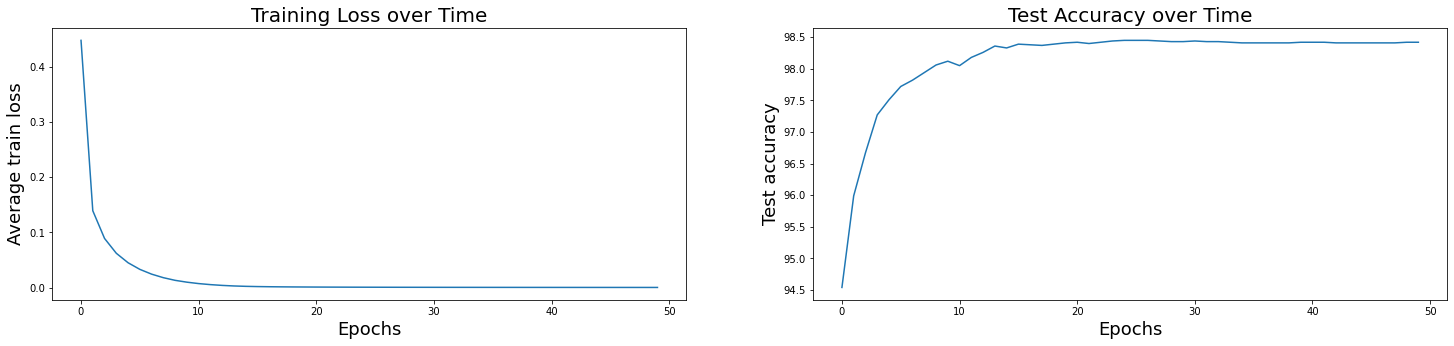

In [16]:
x_axis = np.arange(len(train_loss_over_time))

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(w=25,h=5)
ax[0].plot(x_axis, train_loss_over_time)
ax[0].set_xlabel('Epochs',fontsize=18)
ax[0].set_ylabel('Average train loss',fontsize=18)
ax[0].set_title('Training Loss over Time',fontsize=20)
ax[1].plot(x_axis, test_accuracy_over_time)
ax[1].set_xlabel('Epochs',fontsize=18)
ax[1].set_ylabel('Test accuracy',fontsize=18)
ax[1].set_title('Test Accuracy over Time',fontsize=20)
fig.savefig('mnist_stats.jpg')